In [220]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [223]:
processed_data = "/content/drive/MyDrive/DATA_AZIMUTHAL/cnn_2_data"

In [3]:
import numpy as np

In [4]:
import zipfile

In [222]:
with zipfile.ZipFile(processed_data, 'r') as zip_ref:
  zip_ref.extractall('/content/drive/MyDrive/DATA_AZIMUTHAL/')

In [224]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/DATA_AZIMUTHAL/cnn2_labels.csv')
df.head()

,Image,Label_Exhaustion,Label_Resistance,Label_Tension
0,azo_img0_20240429_055141,Not Diagnosed,Issue,Not Diagnosed
1,azo_img1_20240429_055141,Not Diagnosed,Issue,Not Diagnosed
2,azo_img2_20240429_055141,Not Diagnosed,Issue,Not Diagnosed
3,ale_img0_20240429_055141,Not Diagnosed,Not Diagnosed,Not Diagnosed
4,ale_img1_20240429_055141,Not Diagnosed,Not Diagnosed,Not Diagnosed


In [225]:
import os
import numpy as np
X = []
for file_name in df['Image']:
  path = os.path.join(processed_data,f"{file_name}.npy")

  img = np.load(path)
  X.append(img)

X = np.stack(X)

In [226]:
X.shape

(384, 64, 64, 3)

In [ ]:
df

In [108]:
y = df['Label_Resistance']

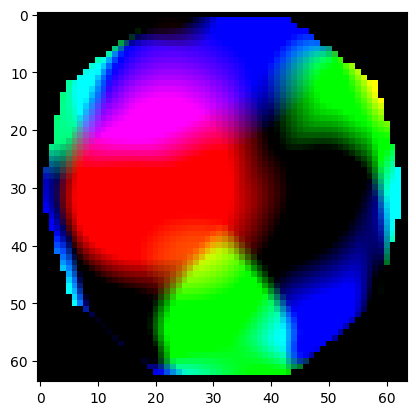

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Create some data
x = X[5]

# Plot the data
plt.imshow(x)
plt.show()

In [ ]:
# Create some data
x = X[10]

# Plot the data
plt.imshow(x)
plt.show()

In [229]:
from sklearn.preprocessing import LabelEncoder
# Convert the data to a categorical array
le = LabelEncoder()
y = le.fit_transform(y)

# Print the categorical array
print(y.shape)

(384,)


## Imbalanced class

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

Train set: (245, 64, 64, 3) (245,)
Validation set: (62, 64, 64, 3) (62,)
Test set: (77, 64, 64, 3) (77,)
{0: 1.2009803921568627, 1: 0.8566433566433567}


In [231]:
num_classes = 2

In [232]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
#Print the shapes of the train, validation, and test sets

## Data augmentation

In [233]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.01,
    height_shift_range=0.01,
    #rescale=1./255,
    fill_mode='nearest'
)
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32  # Batch size to use
)


## scale validation data

In [ ]:
X_test = X_test * 255.0
X_train = X_train * 255.0

In [234]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense,Dropout,BatchNormalization
from keras.regularizers import l2

class NetworkArchFonc:
    @staticmethod
    def build(width, height, depth, num_classes, dropout_p):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if tf.keras.backend.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(16, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        # third set of CONV => RELU => POOL layers

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(Dropout(dropout_p))
        model.add(Dense(num_classes, activation='softmax'))

        # print the model architecture
        model.summary()

        # return the constructed network architecture
        return model


In [75]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [161]:
del model

In [235]:
class_weights_dict

{0: 1.2009803921568627, 1: 0.8566433566433567}

In [238]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
def hyperparams_tune():

  info_training = []
  for batch_size in [32,64]:
    for dropout in [0, 0.3, 0.5, 0.7]:
      for lr in [1e-4, 1e-5]:
        for opt in [0, 1]:

          model = NetworkArchFonc.build(64,64,2,3, dropout)
          # Set initial learning rate and decay
          INIT_LR = lr
          # Option 1: Basic Adam optimizer with a static learning rate


          # Option 2: Adam with learning rate decay using exponential decay schedule
          lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
              initial_learning_rate=INIT_LR,
              decay_steps=20,
              decay_rate=0.9,
              staircase=True)

          if opt == 0:
            opt1 = Adam(learning_rate=lr_schedule)
          else:
            opt1 = SGD(learning_rate=lr_schedule)

          # Choose the optimizer you'd like to use
          model.compile(optimizer=opt1, loss="categorical_crossentropy", metrics=["accuracy"])

          from keras.callbacks import EarlyStopping
          early_stopping = EarlyStopping(
              monitor='val_loss',    # Monitor the validation loss
              min_delta=1e-4,        # Minimum change to qualify as an improvement
              patience=20,           # Number of epochs to wait for improvement
              verbose=2,             # Log when training stops
              mode='auto'            # Infer whether to minimize or maximize the monitored quantity
          )

          epochs = 150
          H = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        class_weight=class_weights_dict,
                        shuffle=True, verbose=2)
          del model
          info_training.append(f"For Batch: {batch_size}, Dropout: {dropout}, Learning Rater: {lr}, Opt : {opt} -- Train loss: {H.history['loss'][-1]}, val loss: {H.history['val_loss'][-1]}, train_acc: {H.history['accuracy'][-1]}, val_acc : {H.history['val_accuracy'][-1]}")
  return info_training

In [ ]:
info = hyperparams_tune()

In [211]:
del model

In [ ]:
model = NetworkArchFonc.build(64,64,3,3, 0.5)
INIT_LR = 1e-5
# Option 1: Basic Adam optimizer with a static learning rate


# Option 2: Adam with learning rate decay using exponential decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=20,
    decay_rate=0.9,
    staircase=True)

opt1 = Adam(learning_rate=lr_schedule)


# Choose the optimizer you'd like to use
model.compile(optimizer=opt1, loss="categorical_crossentropy", metrics=["accuracy"])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    min_delta=1e-4,        # Minimum change to qualify as an improvement
    patience=20,           # Number of epochs to wait for improvement
    verbose=2,             # Log when training stops
    mode='auto'            # Infer whether to minimize or maximize the monitored quantity
)

epochs = 150
H = model.fit(X_train, y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping],
              class_weight=class_weights_dict,
              shuffle=True, verbose=2)

In [ ]:
info

In [ ]:
del model

In [ ]:

epochs = 150
H = model.fit(X_train, y_train,
              batch_size=32,
              validation_split=0.2,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping],
              class_weight=class_weights_dict,
              shuffle=True, verbose=2)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [215]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming model.predict outputs probabilities for classification tasks
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)  # convert from one-hot encoding to class integers

# Assuming y_test is also one-hot encoded
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, predictions, target_names=["Not Diagnosed", "Active Phase", "Mental Issue"]))

3/3 [==============================] - 0s 3ms/step
               precision    recall  f1-score   support

Not Diagnosed       0.33      0.38      0.36        13
 Active Phase       0.17      0.40      0.24         5
 Mental Issue       0.84      0.71      0.77        59

     accuracy                           0.64        77
    macro avg       0.45      0.50      0.45        77
 weighted avg       0.71      0.64      0.67        77



In [31]:
import seaborn as sns

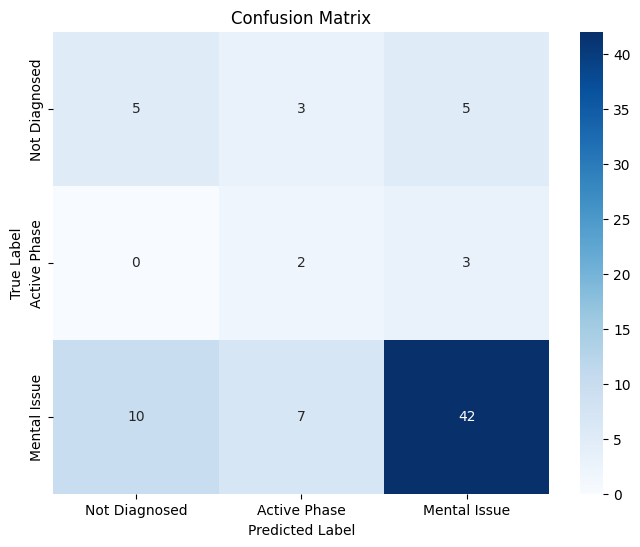

In [216]:
conf_matrix = confusion_matrix(y_test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Diagnosed", "Active Phase", "Mental Issue"], yticklabels=["Not Diagnosed", "Active Phase", "Mental Issue"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()